# 0. Import libraries

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time as time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import imutils
from pycaret.classification import *
import shutil

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### Create functions for object detection and pose estimation using mediapipe

In [2]:
# function for object detection using mediapipe
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [3]:
# function to draw landmark points and landmark connections using Mediapipe's Pose Estimation
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 

In [4]:
# function to calculate angles
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return np.round(angle, 0) 

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

### Create functions to extract the following angles and keypoints

- **angles**

    - right_elbow
    - right_shoulder
    - right_hip
    - right_knee
    - right_ankle
    
    - left_elbow
    - left_shoulder
    - left_hip
    - left_knee
    - left_ankle
    
- **keypoints (x,y,z coordinates)**

    - right_elbow
    - right_shoulder
    - right_hip
    - right_knee
    - right_ankle
    
    - left_elbow
    - left_shoulder
    - left_hip
    - left_knee
    - left_ankle

# Create function to extract keypoints



In [5]:
# function to extract angles from the joints coordinates which were extracted from the Pose Estimation
def extract_angles(results):

    # JOINTS THAT CORRESPONDS TO MEDIAPIPE NUMBER LABELS
    RW = 16
    RE = 14
    RS = 12
    RH = 24
    RK = 26
    RA = 28
    RFI = 32

    LW = 15
    LE = 13
    LS = 11
    LH = 23
    LK = 25
    LA = 27
    LFI = 31
    
    # Instantiating mediapipe landmark object
    RES = results.pose_landmarks


    # ASSIGNING JOINTS ARRAYS
    RIGHT_WRIST = np.array([RES.landmark[RW].x, RES.landmark[RW].y]) if RES else np.zeros(1*2)
    RIGHT_ELBOW = np.array([RES.landmark[RE].x, RES.landmark[RE].y]) if RES else np.zeros(1*2)
    RIGHT_SHOULDER = np.array([RES.landmark[RS].x, RES.landmark[RS].y]) if RES else np.zeros(1*2)
    RIGHT_HIP = np.array([RES.landmark[RH].x, RES.landmark[RH].y]) if RES else np.zeros(1*2)
    RIGHT_KNEE = np.array([RES.landmark[RK].x, RES.landmark[RK].y]) if RES else np.zeros(1*2)
    RIGHT_ANKLE = np.array([RES.landmark[RA].x, RES.landmark[RA].y]) if RES else np.zeros(1*2)
    RIGHT_FOOT_INDEX = np.array([RES.landmark[RFI].x, RES.landmark[RFI].y]) if RES else np.zeros(1*2)
    
    LEFT_WRIST = np.array([RES.landmark[LW].x, RES.landmark[LW].y]) if RES else np.zeros(1*2)
    LEFT_ELBOW = np.array([RES.landmark[LE].x, RES.landmark[LE].y]) if RES else np.zeros(1*2)
    LEFT_SHOULDER = np.array([RES.landmark[LS].x, RES.landmark[LS].y]) if RES else np.zeros(1*2)
    LEFT_HIP = np.array([RES.landmark[LH].x, RES.landmark[LH].y]) if RES else np.zeros(1*2)
    LEFT_KNEE = np.array([RES.landmark[LK].x, RES.landmark[LK].y]) if RES else np.zeros(1*2)
    LEFT_ANKLE = np.array([RES.landmark[LA].x, RES.landmark[LA].y]) if RES else np.zeros(1*2)
    LEFT_FOOT_INDEX = np.array([RES.landmark[LFI].x, RES.landmark[LFI].y]) if RES else np.zeros(1*2)
    
    # CALCULATING ANGLES FROM JOINTS ARRAYS
    angle_RE = calculate_angle(RIGHT_WRIST, RIGHT_ELBOW, RIGHT_SHOULDER)
    angle_RS = calculate_angle(RIGHT_ELBOW, RIGHT_SHOULDER, RIGHT_HIP)
    angle_RH = calculate_angle(RIGHT_SHOULDER, RIGHT_HIP, RIGHT_KNEE)
    angle_RK = calculate_angle(RIGHT_HIP, RIGHT_KNEE, RIGHT_ANKLE)
    angle_RA = calculate_angle(RIGHT_KNEE, RIGHT_ANKLE, RIGHT_FOOT_INDEX)
    
    angle_LE = calculate_angle(LEFT_WRIST, LEFT_ELBOW, LEFT_SHOULDER)
    angle_LS = calculate_angle(LEFT_ELBOW, LEFT_SHOULDER, LEFT_HIP)
    angle_LH = calculate_angle(LEFT_SHOULDER, LEFT_HIP, LEFT_KNEE)
    angle_LK = calculate_angle(LEFT_HIP, LEFT_KNEE, LEFT_ANKLE)
    angle_LA = calculate_angle(LEFT_KNEE, LEFT_ANKLE, LEFT_FOOT_INDEX)

        
    return np.array([angle_RE, angle_RS, angle_RH, angle_RK, angle_RA,angle_LE, angle_LS, angle_LH, angle_LK, angle_LA])

In [6]:
# Function to extract keypoints from joints coordinates which were extracted from the Pose Estimation
def extract_keypoints(results):    

    # uncomment below if using only non-facial keypoints
    # take only visible joints keypoints (total 16 keypoints 11 to 16 and 23 to 32)
#     pose1 = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark[11:17]]).flatten() if results.pose_landmarks else np.zeros(6*3)
#     pose2 = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark[23:33]]).flatten() if results.pose_landmarks else np.zeros(10*3)
#     return np.concatenate([pose1,pose2])

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    return np.concatenate([pose])

___

# 1. Data Extraction

### Set up folders for collection later on

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['right_highkick','left_highkick','right_lowkick','left_lowkick','right_punch','left_punch'])

# num videos per kick
no_sequences_right_highkick = 24
no_sequences_left_highkick = 24
no_sequences_right_lowkick = 24
no_sequences_left_lowkick = 24
no_sequences_rightpunch = 24
no_sequences_leftpunch = 24

# frames are going to be 24 frames in length (24fps)
sequence_length = 24

### Creating folder `MP_Data` to store arrays for each strike type

In [8]:
try:
    shutil.rmtree('MP_Data')
except:
    print('no MP_Data folder, continue to next cell')
    
# for each type of kick
for action in actions: 
    # for each video, create a folder for ==> headkick0, headkick1, ...., headkick29 
    if action == 'right_highkick':
        for sequence in range(no_sequences_right_highkick):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
    elif action == 'left_highkick':
        for sequence in range(no_sequences_left_highkick):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
    elif action == 'right_lowkick':
        for sequence in range(no_sequences_right_lowkick):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
    elif action == 'left_lowkick':
        for sequence in range(no_sequences_left_lowkick):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
    elif action == 'right_punch':
        for sequence in range(no_sequences_rightpunch):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
    elif action == 'left_punch':
        for sequence in range(no_sequences_leftpunch):
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))


### Create function to extract and store Keypoint and Angles from a Video Input

In [9]:
def save_extracted_values(no_sequences, cap, sequence_length=sequence_length):
    for sequence in range(no_sequences):
        # loop thru video length aka frames
        for frame_num in range(sequence_length):

            # read feed per frame
            ret, frame = cap.read()
            if frame is None:
                break

            # make detection using function `mediapipe_detection`
            image, results = mediapipe_detection(frame, pose)
#                 print(results)                

            # draw landmarks
            draw_styled_landmarks(image, results)

            # for the 1st frame, apply STANDBY message to get ready
            if frame_num == 0: 
                cv2.putText(image, 'STANDBY', (50,200), 
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255, 0), 4, cv2.LINE_AA)
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (230, 230, 230), 2, cv2.LINE_AA)
                # Show to screen
                image = cv2.resize(image, (960,540))
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(70)

            # for the 2nd frame onwards, just collect frames without "Standby"
            else: 
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,40), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1.5, (230, 230, 230), 2, cv2.LINE_AA)
                # Show to screen
                image = cv2.resize(image, (960,540))
                cv2.imshow('OpenCV Feed', image) # output frame

            # export keypoints for each video (0th - 29th frames)
            keypoints = extract_keypoints(results) # extract 16*3 keypoints
            angles = extract_angles(results) # extract 10 angles
#                 angles = np.round(angles, 3)
#                 keypoints = np.round(keypoints,3)
            keypoints_angles = np.concatenate([keypoints,angles])
            # save concatenated arrays as csv
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints_angles) # SAVING .npy file into MP_Data folder

            # Break
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

### Run functions to extract data based on input training video
- data will be extracted in array form and saved 

In [11]:
# directory = r'C:\Users\Haziq\Desktop\GA\Capstone\MMA\Mediapipe_LSTM\42punchkicksneutral.mp4'
directory = r'../asset/HK,LK,P_still_images_updated_flipped_24each.mp4'

# video below should show same format of the action array: headkick, bodykick, legkick
cap = cv2.VideoCapture(directory)

# set timer module
start_time = time.time()
print(time.asctime())

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    
    # loop thru each type of kick folder
    for action in actions:
        if action == 'right_highkick':
            save_extracted_values(no_sequences_right_highkick, cap=cap, sequence_length=sequence_length)
        elif action == 'left_highkick':
            save_extracted_values(no_sequences_left_highkick, cap=cap, sequence_length=sequence_length)
        elif action =='right_lowkick':
            save_extracted_values(no_sequences_right_lowkick, cap=cap, sequence_length=sequence_length)
        elif action == 'left_lowkick':
            save_extracted_values(no_sequences_left_lowkick, cap=cap, sequence_length=sequence_length)
        elif action =='right_punch':
            save_extracted_values(no_sequences_rightpunch, cap=cap, sequence_length=sequence_length)
        elif action == 'left_punch':
            save_extracted_values(no_sequences_leftpunch, cap=cap, sequence_length=sequence_length)


    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    
print(time.asctime())

Wed Dec 15 00:34:20 2021
Wed Dec 15 00:37:15 2021


___

# 2. Preprocessing of extracted data


### creating `sequences` and `labels` objects by importing from `MP_Data` folder
- all the arrays for each action will be compiled into one object `sequences`

In [13]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []

def extract_data(action_type:str, num_of_videos):
    for action in actions:
        if action == action_type:
            for sequence in range(num_of_videos):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences.append(window)
                labels.append(label_map[action])

extract_data('right_highkick', no_sequences_right_highkick)
extract_data('left_highkick', no_sequences_left_highkick)
extract_data('right_lowkick', no_sequences_right_lowkick)
extract_data('left_lowkick', no_sequences_left_lowkick)
extract_data('right_punch', no_sequences_rightpunch)
extract_data('left_punch', no_sequences_leftpunch)


### converting `sequences` to moving average values (optional)
- reason for converting to moving average is to "smoothen" the values to account for inaccuracies in pose estimations
- only convert if it is deemed that pose estimation is not consistent

In [14]:
# n = 5 # value to divide to get moving average
# sum_ma_list_list = []
# for idx in range(len(sequences)):
#     sum_ma_list = []
#     for i in range(2, len(sequences[idx])): # remove first 2 frames as there might be anomaly and then loop thru 111 videos
#         if (i+n)<=28:
#             sum_ma = np.array(sum(sequences[idx][i:i+n])/n) # moving average keypoints for the 28 frames, output will be 29-5=24 frames
#             sum_ma_list.append((sum_ma)) # sum_ma_list ==> list of 28 frames with keypoints
#         else:
#             break
#     sum_ma_list_list.append(sum_ma_list) # sum_ma_list_list ==> list of 111 videos with moving average of 23 frames

### setting up dataframe for pycaret (**DROPPING OF ANY KEYPOINTS / ANGLES TO BE DONE HERE, IF ANY**)
- dataframe will include
    - 99 keypoints and 10 angle values (for each frame) per row
    - after multiple tests, we decided to drop the 99 keypoints as they prove to be giving too much noise

In [15]:
# converting the extracted data into DATAFRAME format
sum_ma_list_list = sequences

df = pd.DataFrame()
idx = 0
X = np.array(sequences)

for video in range(X.shape[0]):
    for frame in range(X.shape[1]): # each frame in each video
        df.loc[idx,'attack_type'] = labels[video]
        df.loc[idx,'frame_num'] = frame
        j = 0
        k = 0
        for coordinate in range(X.shape[2]): # each coordinate in each frame
            df.loc[idx,j] = (X[video,frame,k])
            j+=1
            k+=1
        idx+=1

# converting float to int
df = df.astype({'attack_type':int, 'frame_num':int})

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

### converting dataframe column names into its respective keypoint / angle names

In [16]:
# creating list of keypoints from pose estimation
keypoints_list = ['nose','left_eye_inner','left_eye','left_eye_outer','right_eye_inner','right_eye','right_eye_outer',
                  'left_ear','right_ear','mouth_left','mouth_right','left_shoulder','right_shoulder',
                  'left_elbow','right_elbow','left_wrist','right_wrist','left_pinky','right_pinky',
                  'left_index','right_index','left_thumb','right_thumb','left_hip','right_hip',
                  'left_knee','right_knee','left_ankle','right_ankle','left_heel','right_heel',
                  'left_foot_index','right_foot_index']

# creating the 3 dimensions for each keypoints
keypoints_list_3d = []
for i in keypoints_list:
    keypoints_list_3d.append([i+'_x', i+'_y', i+'_z'])
keypoints_list_3d = np.array(keypoints_list_3d).flatten().tolist()

# creating list of angle joints
angle_joints_list = ['right_elbow_angle', 'right_shoulder_angle', 'right_hip_angle', 'right_knee_angle', 
                     'right_ankle_angle', 'left_elbow_angle', 'left_shoulder_angle', 'left_hip_angle', 
                     'left_knee_angle', 'left_ankle_angle']

print('total of {} keypoints'.format(len(keypoints_list_3d)))
print('total of {} angles'.format(len(angle_joints_list)))

full_list = ['attack_type', 'frame_num'] + keypoints_list_3d + angle_joints_list

df.columns = full_list
df = df.astype({'attack_type':int, 'frame_num':int})

total of 99 keypoints
total of 10 angles


### as mentioned earlier, we will take only the 10 angles because the 99 keypoint values prove to be giving more noise than important information

In [21]:
df_anglesonly = pd.merge(df.loc[:,'attack_type'], df.iloc[:,-10:], left_index=True, right_index=True)
df_anglesonly.tail()

,attack_type,right_elbow_angle,right_shoulder_angle,right_hip_angle,right_knee_angle,right_ankle_angle,left_elbow_angle,left_shoulder_angle,left_hip_angle,left_knee_angle,left_ankle_angle
3451,5,39.0,49.0,153.0,174.0,118.0,147.0,72.0,163.0,173.0,91.0
3452,5,36.0,49.0,153.0,174.0,119.0,148.0,73.0,163.0,173.0,91.0
3453,5,37.0,49.0,154.0,174.0,118.0,150.0,74.0,163.0,173.0,92.0
3454,5,35.0,49.0,154.0,174.0,117.0,150.0,74.0,163.0,173.0,89.0
3455,5,35.0,49.0,154.0,174.0,117.0,152.0,75.0,163.0,173.0,90.0


# 3. EDA

### EDA by attack_type

In [22]:
# plot all different angles of each attack_type
# for each kick, average out each angle_num over the frames
num_action = 24 # number of videos per action_type

def plot_action_type_angles(action_type, num_frame=24):
    '''
    action_type => string defining type of action to plot
    num_frame => no. of frames per action_type (this should be 24 for all action_types)
    '''
    actions = {
        'right_highkick': [24*0,24*1],
        'left_highkick': [24*1,24*2],
        'right_lowkick':[24*2,24*3],
        'left_lowkick':[24*3,24*4],
        'right_punch':[24*4,24*5],
        'left_punch':[24*5,24*6],
    } 
    
    frame_avg = np.array([0.0]*10)
    for action in range(actions[action_type][0], actions[action_type][1]):
        for frame in range(num_frame):
            frame_avg += sum_ma_list_list[action][frame][-10:]
    frame_avg /= (num_frame * num_action) # get the average value of all angles for each action_type

    sns.barplot(angle_joints_list,frame_avg)
    plt.title(action_type)
    plt.ylim([0,180])
    plt.xticks(rotation = 50)
    
    return frame_avg

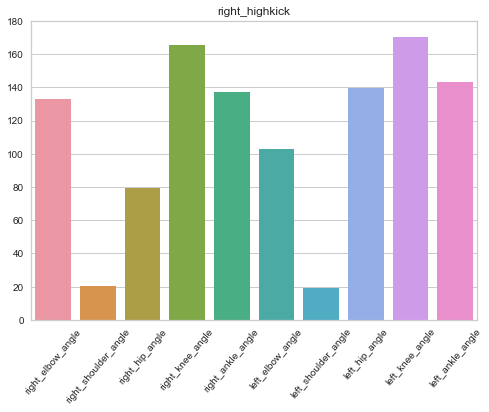

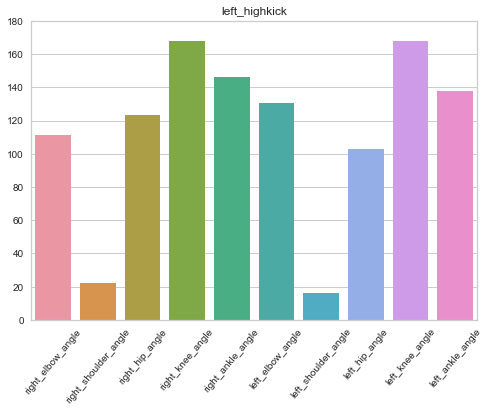

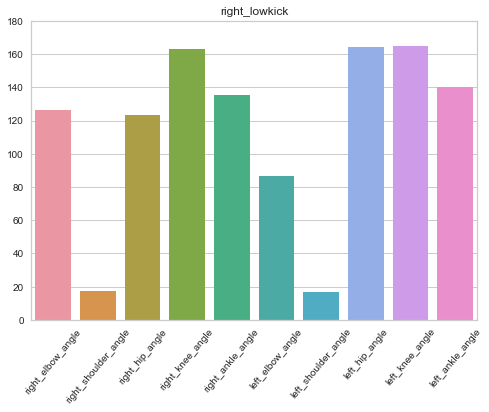

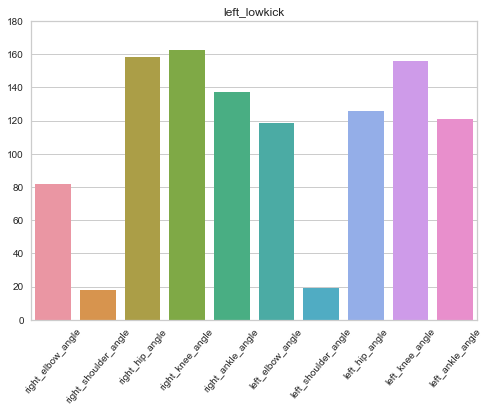

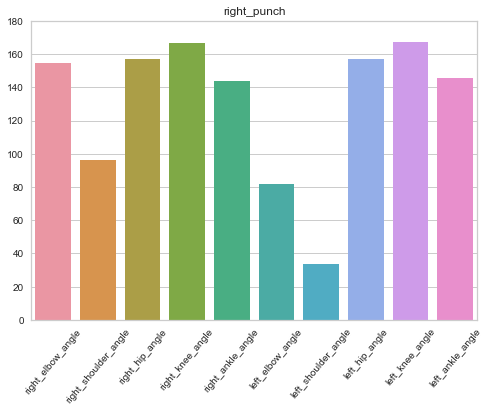

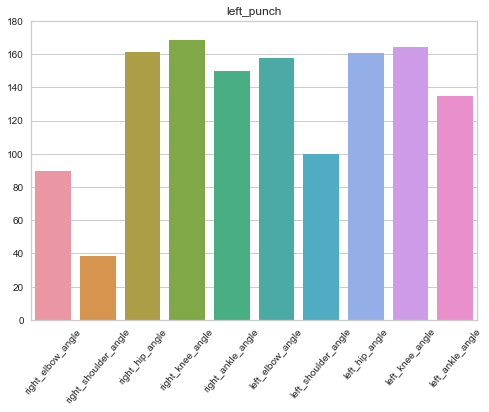

In [23]:
actions = {
    'right_highkick': [24*0,24*1],
    'left_highkick': [24*1,24*2],
    'right_lowkick':[24*2,24*3],
    'left_lowkick':[24*3,24*4],
    'right_punch':[24*4,24*5],
    'left_punch':[24*5,24*6],
} 

df_array = []
for action in actions.keys():
    frame_avg = plot_action_type_angles(action)
    plt.show()
    df_array.append(frame_avg)

### Correlation between features

In [24]:
df = pd.DataFrame(np.array(df_array))
df.columns = [angle_joints_list]
df.index = actions.keys()
df = np.round(df,1)
df = df.astype(int)
df

,right_elbow_angle,right_shoulder_angle,right_hip_angle,right_knee_angle,right_ankle_angle,left_elbow_angle,left_shoulder_angle,left_hip_angle,left_knee_angle,left_ankle_angle
right_highkick,133,20,79,165,137,102,18,139,170,143
left_highkick,111,22,123,168,146,130,16,103,167,137
right_lowkick,126,17,123,163,135,86,16,164,164,140
left_lowkick,81,17,158,162,137,118,19,125,156,121
right_punch,154,96,156,167,144,81,33,157,167,145
left_punch,89,38,161,168,150,157,99,161,164,134


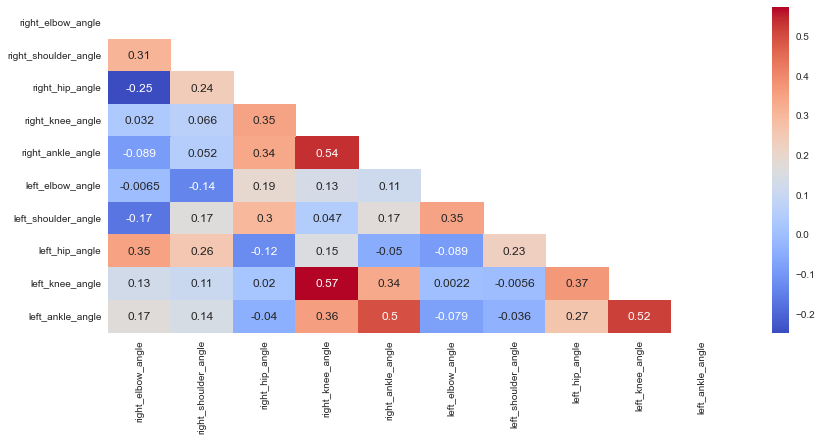

In [33]:
plt.figure(figsize=(14,6))
corr = df_anglesonly.drop(columns='attack_type').corr()
sns.heatmap(corr, 
            annot=True,
            mask = np.triu(np.ones_like(corr, dtype=bool)),
            cmap='coolwarm'
);

- from the correlation heatmap above, we remove the target variable `'attack_type'` since it is a mutli-label classification.
- in general, there are no strong correlation between the angles.
- however, there seems to be moderate correlation between knee and ankle angles

In [26]:
# def plot_angle_over_frames(angle_idx, idx_start, idx_end, num_frame):
#     ''' angle refers to index
#         idx_start : start index of action
#         idx_end : end index of aciton
#     '''
#     frames = []
#     for frame in range(num_frame):
#         kicks = []
#         for kick in range(idx_start, idx_end):
#             kicks.append(sum_ma_list_list[kick][frame][angle_idx])
#         frames.append(kicks)

#     temps = pd.DataFrame(np.array(frames))

#     col_names = [('video'+str(i)) for i in temps.columns]
#     temps.columns = col_names

#     frame_num = [('frame'+str(i)) for i in temps.index]
#     temps.index = frame_num

#     sns.barplot(x=frame_num, y=temps.T.mean());
#     plt.xticks(rotation = 90);

In [27]:
# def plot_all_angles(idx_start, idx_end, num_frame):
#     dicts = {}
#     for i in range(0,10):
#         dicts[i-10] = df_anglesonly.columns[-10:][i]
#     for i in dicts.keys():
#         plt.title(dicts[i])
#         plot_angle_over_frames(i,idx_start, idx_end, num_frame)
#         plt.ylim([0,180])
#         plt.show()

### Save dataframe for use in part 2b

In [28]:
df_anglesonly.to_csv('../data/df_anglesonly.csv', index=False)

___